# **Project Summary**
In this project, we will:

**1. Clustering Analysis**
- K-Means 
- Agglomerative Clustering 
- DBSCAN 

**2. Dimensionality Reduction** 
- PCA 
- t-SNE 

**3. Anomaly Detection** 
- Isolation Forest 
- Local Outlier Factor (LOF)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Data Loading and Exploration
Check data completeness, types, and distributions.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atharvasoundankar/global-cybersecurity-threats-2015-2024")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/anitahuang/.cache/kagglehub/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024/versions/1


In [4]:
import pandas as pd

df = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/global-security-threats/data/Global_Cybersecurity_Threats_2015-2024.csv')
df.head()
# df.info()
# df.describe(include='all')

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


In [5]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64


# 2. Data Preprocessing & Feature Engineering 
- Categorical features encoded for clustering methods.
- Numeric features standardized for equal influence.

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define categorical and numerical columns
categorical_features = ["Country", "Year", "Attack Type", "Target Industry", "Attack Source", "Security Vulnerability Type", "Defense Mechanism Used"]
numerical_features = ["Financial Loss (in Million $)", "Number of Affected Users", "Incident Resolution Time (in Hours)"]

# Standardize numerical features and encode categorical features
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Apply transformations
X_processed = preprocessor.fit_transform(df)

print("Preprocessing completed. Shape of transformed data:", X_processed.shape)

Preprocessing completed. Shape of transformed data: (3000, 49)


# 3. Clustering Analysis 
- This will group similar cybersecurity incidents together.
- Clusters can indicate common attack types, vulnerable industries, or frequent attack sources.

## 3.1 K-Means Clustering

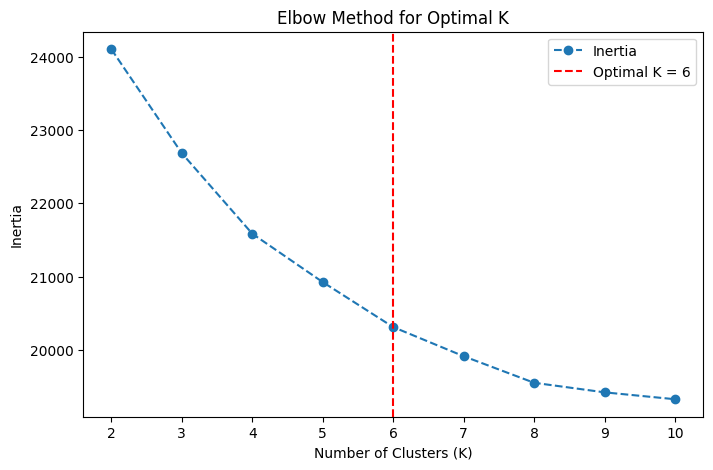

In [7]:
from sklearn.cluster import KMeans
from kneed import KneeLocator  # Automatically detects the "elbow point"

# Define a range of K values to test
K_range = range(2, 11)
inertia = []

# Run K-Means for each K and store inertia values
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# Automatically find the elbow point
knee_locator = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
optimal_k_elbow = knee_locator.elbow

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="--", label="Inertia")
plt.axvline(optimal_k_elbow, color="red", linestyle="--", label=f"Optimal K = {optimal_k_elbow}")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

## Clustering Analysis Main Takeaways
The Elbow Method graph and code indicate that the optimal number of clusters (K) for K-Means clustering is 6.
Since K=6 is the optimal number of clusters, it suggests that the cybersecurity dataset can be effectively segmented into six distinct groups based on attack characteristics.

**Potential cybersecurity threat clusters might represent:**
Cyber attacks across multiple years, industries, and financial impacts naturally fall into six groups.
The clusters might represent:
- High-Financial-Impact Attacks (Large financial loss & long resolution time).
- Frequent, Low-Severity Attacks (E.g., phishing & credential stuffing).
- Industry-Specific Attacks (E.g., finance-focused ransomware).
- Emerging Threats (Newly detected attack types).
- Nation-State or Large-Scale Attacks (Major geopolitical cyber threats).
- Insider Attacks & Data Leaks (Often harder to detect, may have unique characteristics).

**Additional Analysis Done for K = 6:**
- Silhouette Score
- Visualization of Clusters (PCA for 2D Projection)

In [8]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(X_processed)
silhouette_avg = silhouette_score(X_processed, cluster_labels)
print(f"Silhouette Score for K=6: {silhouette_avg}")

Silhouette Score for K=6: 0.06308328558362283


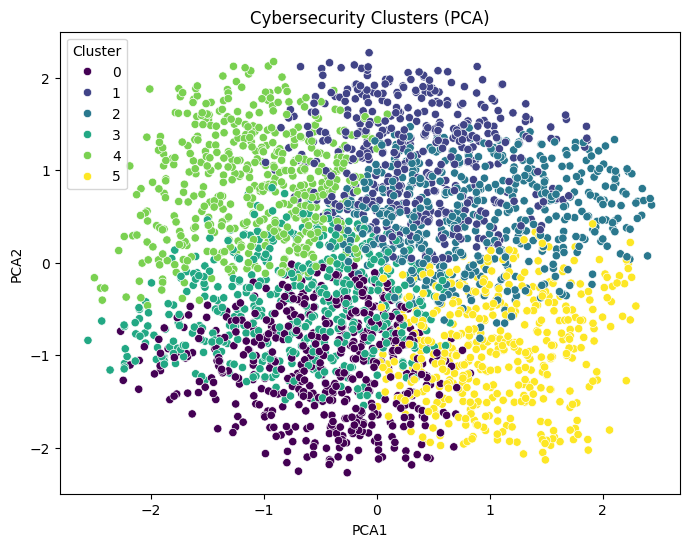

In [9]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

df["PCA1"], df["PCA2"] = X_pca[:, 0], X_pca[:, 1]
df["Cluster"] = cluster_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Cluster", palette="viridis")
plt.title("Cybersecurity Clusters (PCA)")
plt.show()

## 3.2 Agglomerative Clustering (Hierarchical)

- Helps understand the hierarchical structure of attack patterns.
- Can identify related threats that evolve over time.

In [10]:
from sklearn.cluster import AgglomerativeClustering

# Convert sparse matrix to dense
X_dense = X_processed.toarray()  # Converts sparse matrix to NumPy array

# Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=6)
df["Cluster_Agglomerative"] = agg_cluster.fit_predict(X_dense)

In [11]:
print(df["Cluster_Agglomerative"].value_counts())  # See cluster distribution

Cluster_Agglomerative
0    826
1    619
2    512
3    406
4    356
5    281
Name: count, dtype: int64


## 3.3 DBSCAN (Density-Based Clustering)

- Finds arbitrary-shaped clusters and detects outliers (anomalies).
- Does not require specifying K (unlike K-Means).

In [12]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2, min_samples=5)
df["Cluster_DBSCAN"] = dbscan.fit_predict(X_processed.toarray())

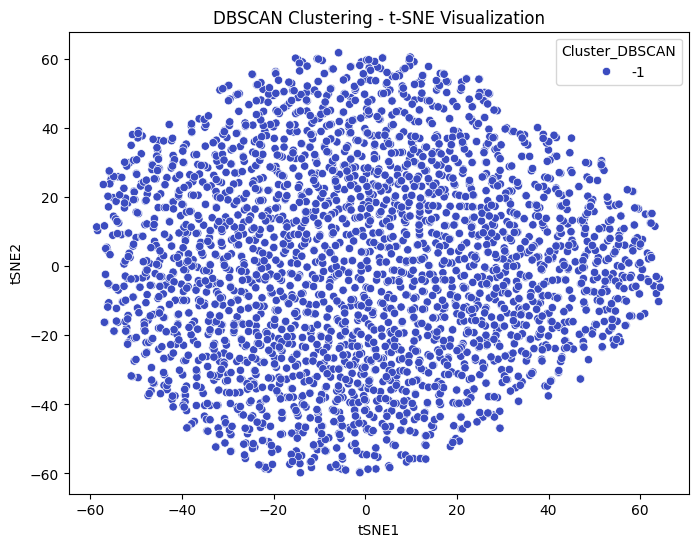

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_processed.toarray())

df["tSNE1"], df["tSNE2"] = X_tsne[:, 0], X_tsne[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="tSNE1", y="tSNE2", hue="Cluster_DBSCAN", palette="coolwarm")
plt.title("DBSCAN Clustering - t-SNE Visualization")
plt.show()

## 4. Dimensionality Reduction (Understanding Cybersecurity Trends in Lower Dimensions) 
Purpose: Reduce high-dimensional cybersecurity threat data while preserving important patterns.

## 4.1 Principal Component Analysis (PCA)
- Reduces dataset to a lower-dimensional space while retaining maximum variance.
- Helps in visualizing cyber threats in 2D.

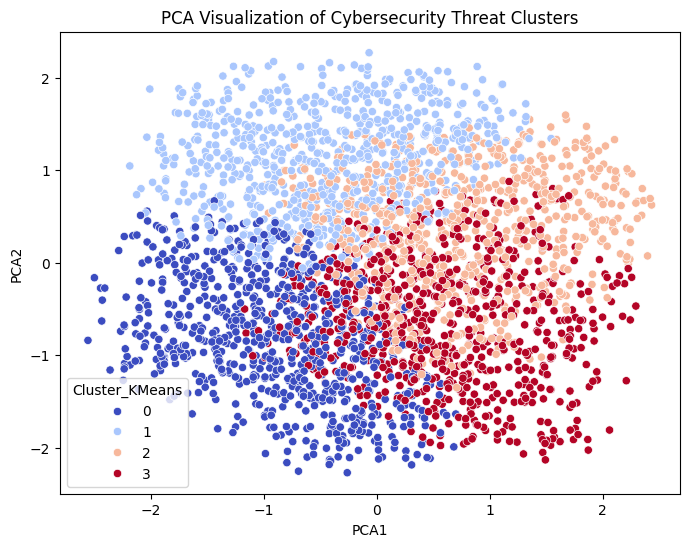

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

df["PCA1"], df["PCA2"] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Cluster_KMeans", palette="coolwarm")
plt.title("PCA Visualization of Cybersecurity Threat Clusters")
plt.show()


**Key Finding:**
- PCA successfully reduced high-dimensional cyber attack data into a 2D space.

**Dataset-Specific Insights:**
- PCA clusters are well-separated, then K-Means found meaningful groupings.

## 4.2 t-SNE (Non-Linear Dimensionality Reduction)
- Captures nonlinear relationships and hidden structures.

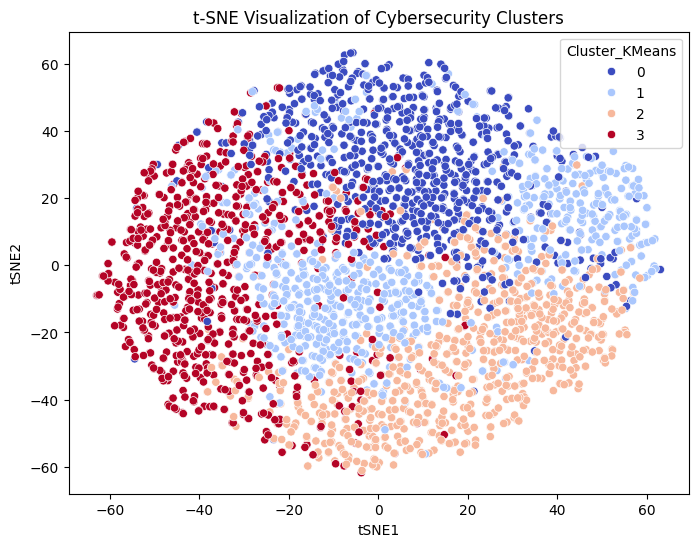

In [47]:
from sklearn.manifold import TSNE

# Convert sparse matrix to dense
X_dense = X_processed.toarray()  # Convert sparse matrix to dense NumPy array

# Apply t-SNE with PCA initialization set to "random"
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="random")
X_tsne = tsne.fit_transform(X_dense)

df["tSNE1"], df["tSNE2"] = X_tsne[:, 0], X_tsne[:, 1]

# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="tSNE1", y="tSNE2", hue="Cluster_KMeans", palette="coolwarm")
plt.title("t-SNE Visualization of Cybersecurity Clusters")
plt.show()

# 5. Anomaly Detection 
- Purpose: Identify rare, high-impact cyberattacks. 

## 5.1 Isolation Forest 
- Flags unusual cyber threats that have extreme values in financial loss, affected users, etc.

In [14]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
df["Anomaly_IsolationForest"] = iso_forest.fit_predict(X_processed)

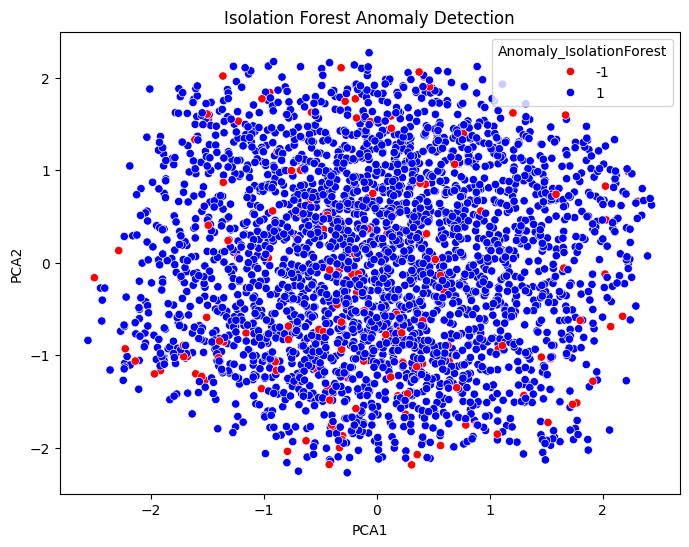

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Anomaly_IsolationForest", palette={1:"blue", -1:"red"})
plt.title("Isolation Forest Anomaly Detection")
plt.show()

## 5.2 Local Outlier Factor (LOF)
- Finds outliers by measuring local density deviations.

In [16]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df["Anomaly_LOF"] = lof.fit_predict(X_processed)

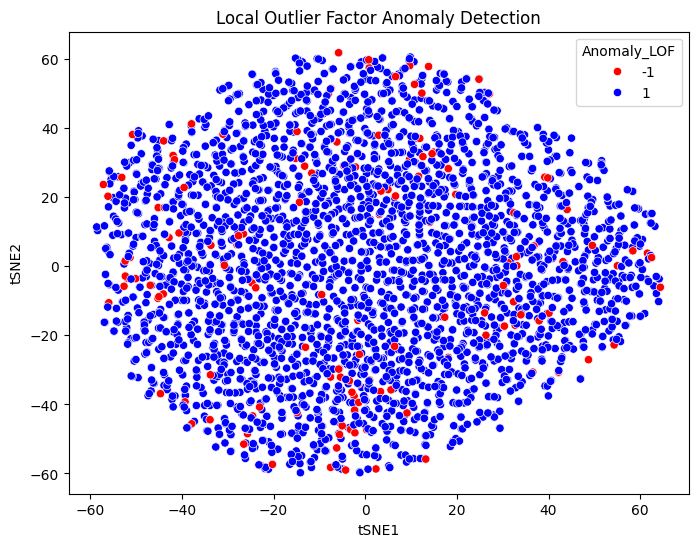

In [17]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="tSNE1", y="tSNE2", hue="Anomaly_LOF", palette={1:"blue", -1:"red"})
plt.title("Local Outlier Factor Anomaly Detection")
plt.show()